# **Multilabel Emotion Classification**

# Overview

Emotion classification, or emotion categorization, is the task of recognising emotions that best represent the mental state of the subject's facial expression, words, and so on. The goal of this lab is to learn how to understand mutli-lable emotion expressions of the Reddit comments as the input text to classify them into the corresponding emotion category. Multi-label Emotion Classification (MEC) is a supervised classification task to determine the presence of multiple emotions in a given piece of text. Single-label Emotion Classification captures only one emotion in text whereas MEC captures all present emotions which best represent the mental state of the writer. In this lab, we will focus on Naive Bayes classifier and SVM.

# Dataset

GoEmotions [Demszky et al., ACL 2020] (https://arxiv.org/pdf/2005.00547.pdf) is a human-annotated dataset of 58k (train: 43410, val: 5426, test: 5427) Reddit comments extracted from popular English-language subreddits and labeled with 27 emotion categories. The dataset includes 12 positive, 11 negative, 4 ambiguous emotion categories and 1 “neutral”. Not limited to the basic six emotions (fear, anger, joy, sadness, disgust, and surprise) makes it widely suitable for conversation understanding tasks that require a subtle differentiation between emotion expressions.

|&emsp;&emsp; Comment &emsp;&emsp;&emsp;&emsp; | &emsp;&emsp;&emsp;&emsp; Emotion Category &emsp; |
|-|:-|
|1.&emsp;&emsp; OMG, yep!!!That is the final answer! Thank you so much!|&emsp;&emsp;&emsp;&emsp;&emsp;🤩&emsp;👍&emsp;🙏|
|2.&emsp;&emsp; I am so glad this is over.|&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 😌|
|3.&emsp;&emsp; Sorry, I feel bad for having said that.|&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 😔|

* `Comment 1` expresses several emotions at once, including excitement, approval and gratitude.
* `Comment 2` expresses relief, a complex emotion conveying both positive and negative sentiment.
* `Comment 3` conveys remorse, a complex emotion that is expressed frequently but is not captured by simple models of emotion.




# 1. Dataset Loading and Preparing

In [1]:
!pip install transformers >> NULL

In [2]:
import nltk
import numpy as np
import pandas as pd
import gensim
import transformers
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1.1. Dataset Loading






In [3]:
# Load Goemotion dataset
!pip install datasets >> NULL
from datasets import load_dataset
dataset = load_dataset("go_emotions", "simplified")
#dataset = dataset.data
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
df_train.head()

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [5]:
# Check the size of each set (train, val, test)
print("Size of train set: ", df_train.shape[0] == 43410)
print("Size of train set: ", df_test.shape[0] == 5427)

Size of train set:  True
Size of train set:  True


In [6]:
emotion_list = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
print(len(emotion_list))

28


In [7]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [8]:
df_train['Emotions'] = df_train['labels'].apply(idx2class)
df_test['Emotions'] = df_test['labels'].apply(idx2class)

In [9]:
df_train.head()

,text,labels,id,Emotions
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral]
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger]
3,To make her feel threatened,[14],ed7ypvh,[fear]
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance]


# 1.2. Emotion Mapping

In [10]:
ekman_mapping = {
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"]
}

In [11]:
def EmotionMapping(emotion_list):
    map_list = []
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')   
    return map_list

In [12]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_test['Mapped Emotions'] = df_test['Emotions'].apply(EmotionMapping)

In [13]:
df_train.head()

,text,labels,id,Emotions,Mapped Emotions
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],[anger]
3,To make her feel threatened,[14],ed7ypvh,[fear],[fear]
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],[anger]


In [14]:
# label encoded vectors
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
  df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
  df_test[i] = df_test['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
#for i in emotion_list:
    #df_train[i] = df_train['Emotions'].apply(lambda x: 1 if i in x else 0)
    #df_test[i] = df_test['Emotions'].apply(lambda x: 1 if i in x else 0)

In [15]:
#train.loc[0]
df_train.head()

,text,labels,id,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],[anger],1,0,0,0,0,0,0


In [16]:
df_train.drop(['labels', 'id', 'Emotions', 'Mapped Emotions'], axis=1, inplace=True)
df_test.drop(['labels', 'id', 'Emotions', 'Mapped Emotions'], axis=1, inplace=True)

In [17]:
df_train.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0,0


# 2. Emotion Analysis on GoEmotion Dataset

In [18]:
categories = list(df_train.columns.values)
categories = categories[1:]
print(categories)

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']


In [19]:
counts = []
for category in categories:
    counts.append((category, df_train[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,anger,5579
1,disgust,793
2,fear,726
3,joy,17410
4,sadness,3263
5,surprise,5367
6,neutral,14219


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


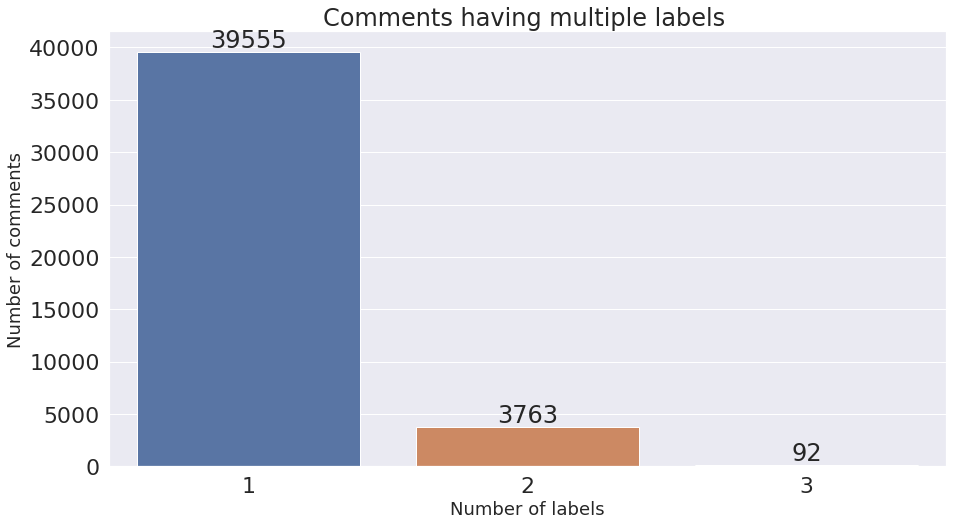

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

rowSums = df_train.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

WordCloud representation is useful to find most used words in each emotion

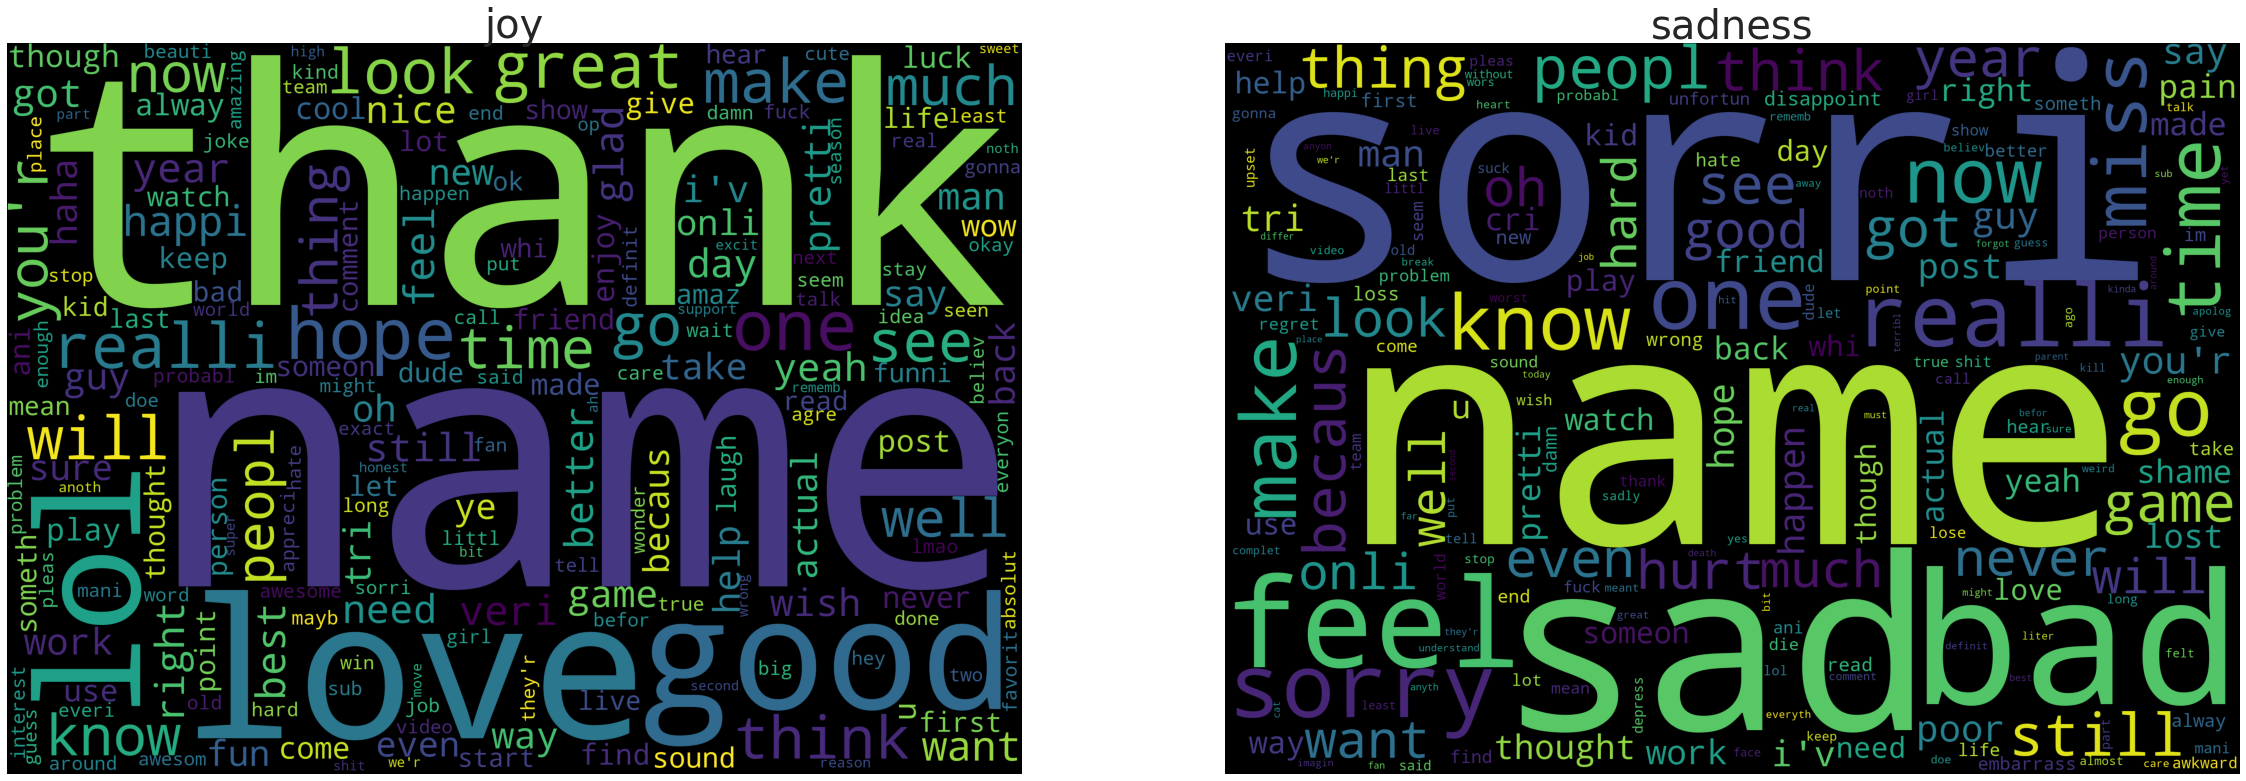

In [36]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# joy
subset = df_train[df_train.joy==1]
text = subset.text.values
cloud_joy = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("joy",fontsize=40)
plt.imshow(cloud_joy)


# sadness

#Excercie1: put your code here

plt.show()

# 3. Data Pre-processing

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 3.1. Cleaning Data

In [22]:
def remove_space(text):
    '''Removes awkward spaces'''
    text = text.strip()
    text = text.split()
    return " ".join(text)

def cleanPunc(text): 
    '''function to clean the word of any punctuation or special characters'''
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(text):
    alpha_sent = ""
    for word in text.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = remove_space(text)
    text = cleanPunc(text)
    text = keepAlpha(text)
    return text

In [23]:
df_train['clean_text'] = df_train['text'].str.lower()
df_train['clean_text'] = df_train['text'].apply(text_preprocessing_pipeline)
df_test['clean_text'] = df_test['text'].apply(text_preprocessing_pipeline)
df_train.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral,clean_text
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1,My favourite food is anything I didnt have to ...
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1,Now if he does off himself everyone will think...
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0,WHY THE FUCK IS BAYLESS ISOING
3,To make her feel threatened,0,0,1,0,0,0,0,To make her feel threatened
4,Dirty Southern Wankers,1,0,0,0,0,0,0,Dirty Southern Wankers


# 3.2. Stemming

In [24]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
  # Exersice: put your code here

df_train['clean_text'] = df_train['clean_text'].apply(stemming)
df_train.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral,clean_text
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1,my favourit food is anyth i didnt have to cook...
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1,now if he doe off himself everyon will think h...
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0,whi the fuck is bayless iso
3,To make her feel threatened,0,0,1,0,0,0,0,to make her feel threaten
4,Dirty Southern Wankers,1,0,0,0,0,0,0,dirti southern wanker


# Emotion Analysis with ML approaches
# 4. Naive Bias Classifier

Naive Bayes is a generative classification model. A generative model learns parameters by maximizing the joint probability  𝑃(𝑋,𝑌)  through Bayes' rule by learning  𝑃(𝑌)  and  𝑃(𝑋|𝑌)  (where  𝑋  are features and  𝑌  are labels).

Prediction with Naive Bias

$$P\bigg(label|features\bigg) = \frac{P(label) \times P(features|label)}{P(features)}$$

Assumption that all features are independant modifies the formula to:

$$P\bigg(label|features\bigg)= \frac{P(label) * P\big(f1|label\big)*...  * P\big(fn|label\big)}{P(features)}$$


Features can be treated using TF-IDF approaches.

In [25]:
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

In [32]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(df_train['clean_text'])
xtest_tfidf = tfidf_vectorizer.transform(df_test['clean_text'])

In [33]:
ytrain = np.asarray(df_train[df_train.columns[1:7]])
ytest = np.asarray(df_test[df_test.columns[1:7]])
print(ytrain.shape)
print(ytest.shape)

(43410, 6)
(5427, 6)


# Problem Transformation
In this method, we will try to transform our multi-label problem into single-label problem(s). This method can be carried out in three different ways as:

1. Binary Relevance
2. Classifier Chains
3. Label Powerset



# 4.1. Binary Relevance
This is the simplest technique, which basically treats each label as a separate single class classification problem. For example, let us consider a case as shown below. We have the data set like this, where X is the independent feature and Class’s are the target variable. In binary relevance, this problem is broken into 3 different single class classification problems as shown in the figure below.



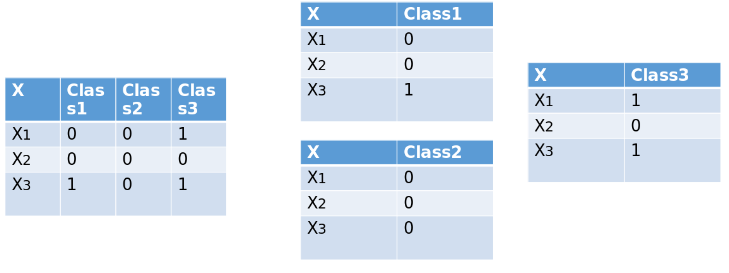

In [34]:
# using binary relevance
!pip install scikit-multilearn >> NULL
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(MultinomialNB())

# train
classifier.fit(xtrain_tfidf, ytrain)

# predict
ytest_br = classifier.predict(xtest_tfidf)

In [35]:
print(classification_report(ytest, ytest_br))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.00      0.00       726
           1       0.00      0.00      0.00       123
           2       0.00      0.00      0.00        98
           3       0.76      0.48      0.59      2104
           4       1.00      0.01      0.02       379
           5       1.00      0.01      0.01       677

   micro avg       0.77      0.25      0.37      4107
   macro avg       0.63      0.08      0.10      4107
weighted avg       0.83      0.25      0.31      4107
 samples avg       0.19      0.18      0.18      4107



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4.2. Classifier Chains
The Binary Relevance is most simple and efficient method but the only drawback of this method is that it doesn’t consider labels correlation because it treats every target variable independently. In Classifier Chains, the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.  

Let’s try to this understand this by an example. In the dataset given below, we have X as the input space and Class’s as the labels. In classifier chains, this problem would be transformed into 3 different single label problems, just like shown below. Here green colored is the input space and the light blue part represent the target variable. This is quite similar to binary relevance, the only difference being it forms chains in order to preserve label correlation. 

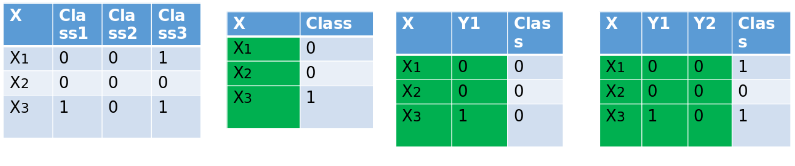

In [36]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
 
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier

# Exercise: put your code here

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       726
           1       0.00      0.00      0.00       123
           2       0.00      0.00      0.00        98
           3       0.73      0.53      0.61      2104
           4       1.00      0.01      0.02       379
           5       1.00      0.01      0.01       677

   micro avg       0.73      0.27      0.40      4107
   macro avg       0.62      0.09      0.11      4107
weighted avg       0.81      0.27      0.32      4107
 samples avg       0.21      0.20      0.20      4107



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4.3. Label Powerset
In this, we transform the problem into a multi-class problem with one multi-class classifier is trained on all unique label combinations found in the training data. So, label powerset has given a unique class to every possible label combination that is present in the training set.

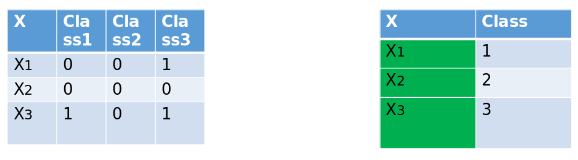

In [37]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import MultinomialNB

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(MultinomialNB())

# train
classifier.fit(xtrain_tfidf, ytrain)

# predict
ytest_powerset = classifier.predict(xtest_tfidf)

print(classification_report(ytest, ytest_powerset))

              precision    recall  f1-score   support

           0       0.82      0.04      0.08       726
           1       0.00      0.00      0.00       123
           2       0.00      0.00      0.00        98
           3       0.47      0.85      0.61      2104
           4       1.00      0.02      0.04       379
           5       1.00      0.01      0.01       677

   micro avg       0.48      0.45      0.46      4107
   macro avg       0.55      0.15      0.12      4107
weighted avg       0.64      0.45      0.33      4107
 samples avg       0.34      0.32      0.33      4107



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Exercise: Repeat the last classifier for text without pre-processing

Conclusion: Compare the classification reports for different NB strategies and discuse pros and cons of the approches. Which strategy works well for each label?



# 5. SVM (Optional)

In [37]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [38]:
ytrain_svm = [0] * len(ytrain)
for i in range(0,len(ytrain)):
  ytrain_svm[i] = ''.join(str(item) for item in ytrain[i])

ytest_svm = [0] * len(ytest)
for i in range(0,len(ytest)):
  ytest_svm[i] = ''.join(str(item) for item in ytest[i])

In [49]:
print(ytest[0])
print(ytest_svm[0])

[0 0 0 0 1 0 0]
0000100


In [39]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(xtrain_tfidf[:10000], ytrain_svm[:10000])
#poly = svm.SVC(kernel='poly', degree=3, C=1).fit(xtrain_tfidf, ytrain_svm)

In [42]:
#poly_pred = poly.predict(xtest_tfidf)
svm_pred = rbf.predict(xtest_tfidf)

In [43]:
rbf_accuracy = accuracy_score(ytest_svm, svm_pred)
rbf_f1 = f1_score(ytest_svm, svm_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  35.71
F1 (RBF Kernel):  20.89
